In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import csv
import os

Import dataset

In [3]:
#==== Import Dataset ====
dataset = pd.read_csv('/content/drive/MyDrive/PercobaanTA/Dataset_KUKA_baru_bersih.csv')

pose = dataset.iloc[:, 6:]   # Input labels (last six columns)
jointsAngle = dataset.iloc[:, :6]   # Output features (first six columns)

pose_columns = ['Position x', 'Position y', 'Position z', 'Roll', 'Pitch', 'Yaw']  # Replace with your actual column names
jointsAngle_columns = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6']  # Replace with your actual column names

#==== Split Dataset ====
split_index = int(0.8 * len(dataset))


jointsAngle_train = jointsAngle[:split_index].values
jointsAngle_test = jointsAngle[split_index:].values
pose_train = pose[:split_index].values
pose_test = pose[split_index:].values


Eksperiment configuration

Epoch 1/3000
39/39 [==============================] - 3s 12ms/step - loss: 3824.1382 - val_loss: 1263.3625
Epoch 2/3000
39/39 [==============================] - 0s 3ms/step - loss: 896.9988 - val_loss: 1806.8428
Epoch 3/3000
39/39 [==============================] - 0s 3ms/step - loss: 670.7379 - val_loss: 1942.6519
Epoch 4/3000
39/39 [==============================] - 0s 3ms/step - loss: 489.5691 - val_loss: 2016.4293
Epoch 5/3000
39/39 [==============================] - 0s 3ms/step - loss: 307.2162 - val_loss: 1787.0948
Epoch 6/3000
39/39 [==============================] - 0s 3ms/step - loss: 165.5148 - val_loss: 1304.6016
Epoch 7/3000
39/39 [==============================] - 0s 4ms/step - loss: 110.0789 - val_loss: 1132.7784
Epoch 8/3000
39/39 [==============================] - 0s 6ms/step - loss: 92.6736 - val_loss: 862.4449
Epoch 9/3000
39/39 [==============================] - 0s 6ms/step - loss: 81.5898 - val_loss: 997.3613
Epoch 10/3000
39/39 [==============================] - 0s

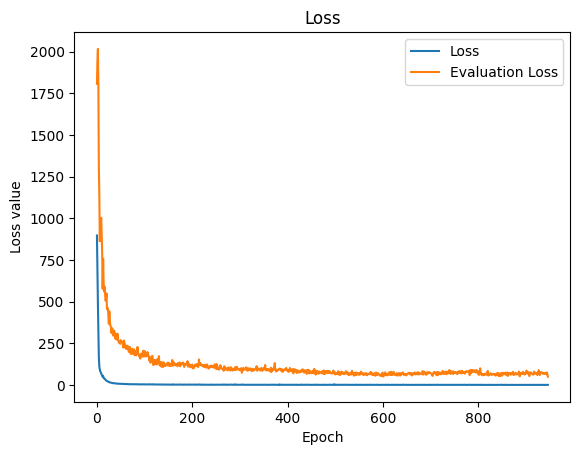

49.74929428100586
0.6066341400146484
10/10 [==============================] - 0s 2ms/step
[[-5.15894775e+01 -1.08962341e+02  1.36997421e+02  5.17893372e+01
   4.59389877e+01 -8.69724274e+01]
 [-5.02350082e+01 -1.08107544e+02  1.36448654e+02  5.20155334e+01
   4.48484116e+01 -8.63003540e+01]
 [-4.90740433e+01 -1.07374855e+02  1.35978271e+02  5.22094231e+01
   4.39136543e+01 -8.57242737e+01]
 ...
 [-1.76305103e+01 -8.52163086e+01  1.07931458e+02  1.90916481e+01
   2.38846378e+01 -4.02277832e+01]
 [-3.86910605e+00 -1.24114044e+02  1.11926353e+02 -2.85849547e+00
   4.57601700e+01 -5.79385519e+00]
 [-1.33582875e-01 -1.38345612e+02  1.20201370e+02  2.39466026e-01
   6.43366241e+01  3.21814269e-01]]


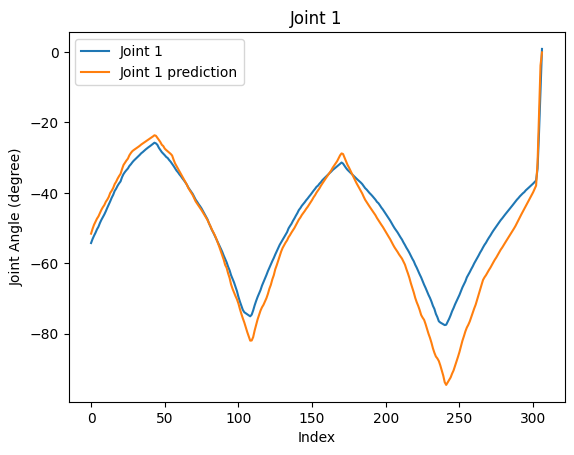

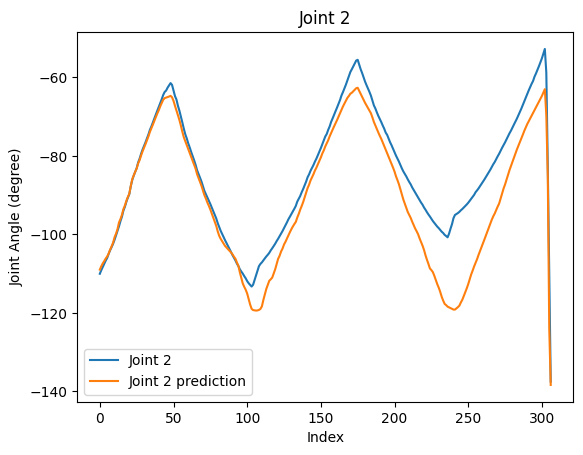

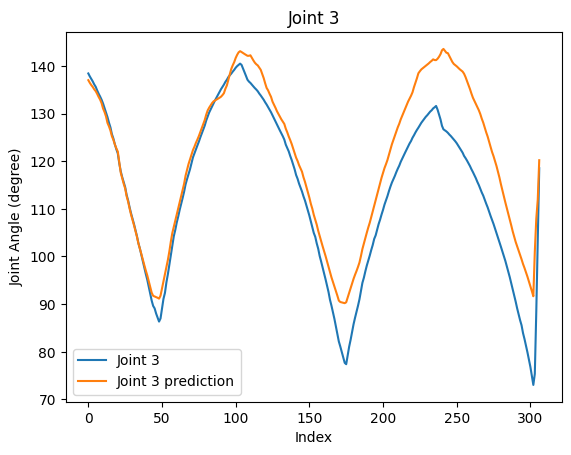

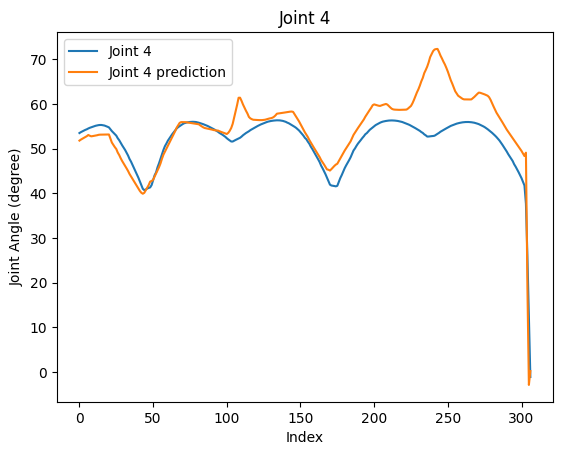

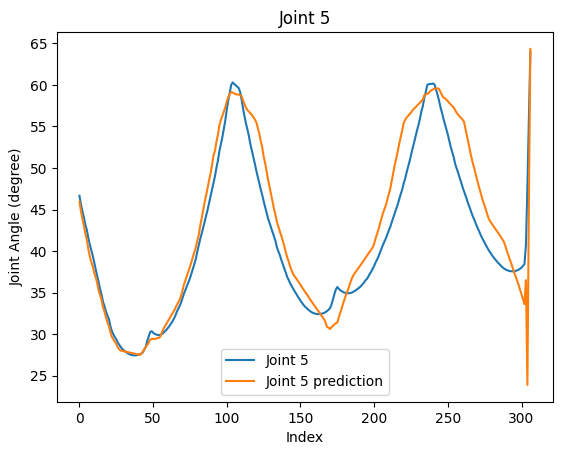

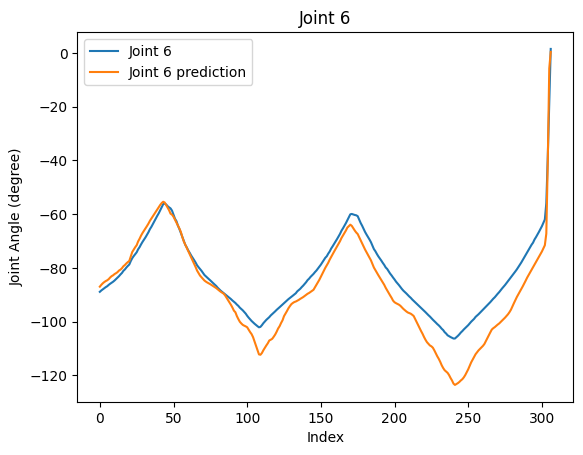

KeyError: ignored

In [4]:
neuron = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 150, 200, 250,300]
windowSize = [1, 4]

for windowSizei in windowSize:
  #==== Generate time series dataset ====
  windowed_pose_train = []
  windowed_jointsAngle_train = []

  windowed_pose_test = []
  windowed_jointsAngle_test = []

  for i in range(len(pose_train) - windowSizei + 1):
      windowed_pose_train.append(pose_train[i : i + windowSizei])
      windowed_jointsAngle_train.append(jointsAngle_train[i + windowSizei - 1])

  for i in range(len(pose_test) - windowSizei + 1):
      windowed_pose_test.append(pose_test[i : i + windowSizei])
      windowed_jointsAngle_test.append(jointsAngle_test[i + windowSizei - 1])

  windowed_pose_train = np.array(windowed_pose_train)
  windowed_jointsAngle_train = np.array(windowed_jointsAngle_train)

  windowed_pose_test = np.array(windowed_pose_test)
  windowed_jointsAngle_test = np.array(windowed_jointsAngle_test)

  for neuroni in neuron:
    #Folder for saving the data
    folder_path = '/content/drive/MyDrive/PercobaanTA/RNN/RNN'+'_'+str(windowSizei)+'_3_'+str(neuroni)
    if os.path.exists(folder_path):
          continue
    os.makedirs(folder_path, exist_ok=True)



    #==== LSTM Model ====
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.SimpleRNN(neuroni, activation='relu',  input_shape=(windowSizei, 6), return_sequences=True))
    model.add(tf.keras.layers.SimpleRNN(neuroni, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.SimpleRNN(neuroni, activation='relu'))
    #model.add(Flatten())
    model.add(Dense(6))

    model.compile(optimizer='adam', loss='mse')

    #==== Target Function ====
    class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss') <= 50): # Experiment with changing this value
          print("\nReached loss less than 0.2 so cancelling training!")
          self.model.stop_training = True

    #==== Train Model ====
    callbacks = myCallback()


    #history = model.fit(pose_train, jointsAngle_train, epochs=3000, batch_size=32, callbacks=[callbacks])

    history = model.fit(windowed_pose_train, windowed_jointsAngle_train, epochs=3000, batch_size=32, validation_data=(windowed_pose_test, windowed_jointsAngle_test), callbacks=[callbacks])

    # Plot loss data
    loss_data = history.history['loss']
    loss_data_plotted = loss_data[1:]

    val_loss_data = history.history['val_loss']
    val_loss_data_plotted = val_loss_data[1:]

    plt.figure()
    plt.plot(range(len(loss_data_plotted)), loss_data_plotted, label='Loss')
    plt.plot(range(len(val_loss_data_plotted)), val_loss_data_plotted, label='Evaluation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss value')
    plt.title('Loss')
    plt.legend()
    # Save loss plot
    plt.savefig(os.path.join(folder_path, 'loss.png'))
    plt.show()

    print(val_loss_data[-1])
    print(loss_data[-1])

    # Write loss and eval loss value
    loss_file = folder_path + '/loss.txt'

    # Open the file in write mode
    with open(loss_file, 'w') as file:
        # Write content to the file
        file.write('Loss = '+str(loss_data[-1])+'\n')
        file.write('Eval loss = '+str(val_loss_data[-1])+'\n')
        file.write('Epoch = '+str(len(loss_data))+'\n')

    #==== Prediction Test ====
    pose_predict = model.predict(windowed_pose_test)

    print(pose_predict)

    # Save prediction data into csv file
    header = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6']
    rows = pose_predict.tolist()  # Convert predictions to a list
    csv_file = folder_path + '/Predictions_KUKA.csv'

    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(rows)

    i = 0
    jointsAngle_test = jointsAngle[split_index:]
    joint = 1
    # Plot joint angle test data and joint angle prediction
    for column in jointsAngle_test:
        input_data = jointsAngle_test[column]
        predict_data = pose_predict[:, i]
        i = i+1
        plt.figure()
        plt.plot(range(len(input_data)), input_data, label=column)
        plt.plot(range(len(predict_data)), predict_data, label = column + ' prediction')
        plt.xlabel('Index')
        plt.ylabel('Joint Angle (degree)')
        plt.title(column)
        plt.legend()
        # Save plot to folder
        plt.savefig(os.path.join(folder_path, 'A'+str(joint)+'.png'))
        joint = joint+1
        plt.show()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')